Welcome to the National Water Model (NWM) Sandbox! This Jupyter Notebook contains Python code that will allow you to explore NWM forecasts for any river segment covered by the NWM. Run each cell in the order that they appear by hitting the play icon at the top of your screen and be sure to read the comments and notes that are included along the way.

The next cell installs or imports all of the modules or packages that will be used in this notebook. We import the date type from the datetime module which will allow us to call todays date. The os module allows us to communicate with the operating system. The requests module lets us make requests to web pages. xarray is a package that will let us work with multidimensional datasets like our NWM forecasts. The matplotlib library will help us create some plots. 

In [4]:
from datetime import date
import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
# Set-up inline plots using matplotlib
%matplotlib inline

The next code cell defines all of the functions that are used in the notebook. Short descriptions are provided next to each function. Try to understand how they work by reading through the code. The first function builds the URL that represents a given forecast. The next function downloads the given forecast from NOAA. The third function gets a time series of data for a given stream segment and uses the first two functions to help create the time series.

In [5]:
# This function builds the url for a specific forecast from the 
# NOAA NWM http file delivery index (https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/)
# The urls are similar to this one:
# https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  # ForecastStartDate = date.today.strftime('%Y%m%d')
  ForecastStartDate

  # Different forecast lengths have slightly different urls. The if elif statements help treat each forecast appropriately so that valid urls are built.
  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'


# This function downloads the appropriate forecast's file from NOAA using a url
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  return FileName


# This function gets a time series of data for a stream segment by building time steps and looping through them
def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

The next few cells use our previously defined functions to get a forecast for a river and display it on a matplotlib plot. Feel free to try changing the variables in the '# Variables' cell. If you choose not to make any changes it should provide you with today's short range forecast for the Colorado River near Glenwood Springs, Colorado. Depending on the forecast that you've chosen these cells could take a while to run. 

Notes: 
1) The medium range forecast has 10 members. But Member 1 is 10 days long while members 2-9 are 8.5 days long
2) The units of the data are cubic meters per second (not cfs)
3) Dates need to be specified in yyyymmdd format and only today or yesterday may be used
4) If you would like to obtain a different StreamID/ReachID, you can do so by clicking on a river of interest at https://water.noaa.gov/map. 

In [6]:
# This gets todays date, stores it in yyyymmdd format and assigns it to the variable 'today' which we use in the next cell
today = date.today()
print(today)
today = str(today)
today = today.replace("-", "")
print(today)

2021-05-21
20210521


In [38]:
# Variables
# The unique identifier corresponding to a river segment:
StreamID = 3175546            

# Date in YYYYMMDD format, can only be today or yesterday. Here we call our variable 'today' from the previous cell:
ForecastStartDate = today  

# Timestep forecast was issued, 00 = midnight CST (Central Standard Time), Cannot exceed 24, 
# Cannot be in the future (Example: Today two hours from now)
# For short_range can be 00, 01, 02, 03, etc.
# For medium_range or long_range can be 00, 06, 12, etc.:
ForecastStartTimestep = '00'       

# Options are 'short_range', 'medium_range', and 'long_range':
ForecastType = 'short_range'       

# Should be 1 for short_range. If using medium_range or 'long_range' then specify the ensemble member 
# (1-4 for long_range or 1-7 for medium_range):
ForecastMember = '1'                

# Now we use the GetSeries function from above, and provide it with the arguments as defined above.
Series = GetSeries(StreamID, ForecastStartDate, ForecastStartTimestep, ForecastType, ForecastMember)
print(Series)

# medium_range for members 2-9 doesn't usually work... and long_range for members 3 and 4 sometimes works

[92.61999792978168, 90.5999979749322, 89.00999801047146, 87.62999804131687, 86.77999806031585, 85.56999808736145, 84.1699981186539, 82.7299981508404, 81.29999818280339, 79.89999821409583, 78.56999824382365, 77.33999827131629, 76.21999829635024, 75.18999831937253, 74.25999834015965, 73.43999835848808, 72.70999837480485, 72.07999838888645]


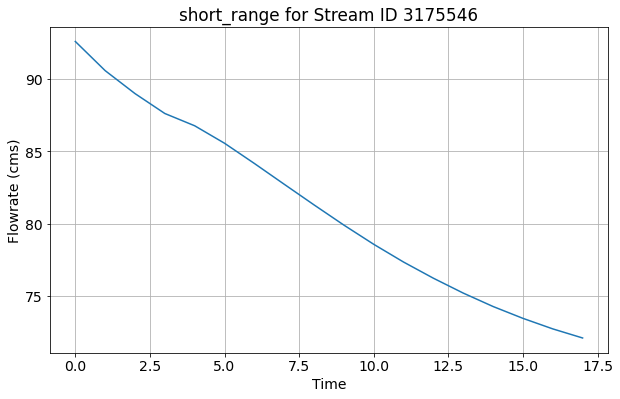

In [39]:
# Now lets draw a plot for the series
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(ForecastType + ' for Stream ID ' + str(StreamID))
ax.grid(True)

The next cell erases the forecast files that were downloaded previously. You can see the files on the left hand side of your screen by clicking on the folder icon prior to running the cell. The cell is also written so that it will print out the name of each file that it removes/deletes.

In [35]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Look at every file and if contains 'nwm' then remove/delete it! 
    if "nwm" in f:
        print(f)
        os.remove(f)

nwm.t00z.medium_range.channel_rt_4.f126.conus.nc
nwm.t00z.medium_range.channel_rt_2.f027.conus.nc
nwm.t00z.medium_range.channel_rt_2.f108.conus.nc
nwm.t00z.medium_range.channel_rt_4.f177.conus.nc
nwm.t00z.medium_range.channel_rt_4.f141.conus.nc
nwm.t00z.medium_range.channel_rt_4.f033.conus.nc
nwm.t00z.medium_range.channel_rt_4.f171.conus.nc
nwm.t00z.medium_range.channel_rt_2.f024.conus.nc
nwm.t00z.medium_range.channel_rt_4.f063.conus.nc
nwm.t00z.medium_range.channel_rt_2.f105.conus.nc
nwm.t00z.medium_range.channel_rt_4.f108.conus.nc
nwm.t00z.medium_range.channel_rt_2.f009.conus.nc
nwm.t00z.medium_range.channel_rt_4.f132.conus.nc
nwm.t00z.medium_range.channel_rt_2.f069.conus.nc
nwm.t00z.medium_range.channel_rt_4.f051.conus.nc
nwm.t00z.medium_range.channel_rt_2.f111.conus.nc
nwm.t00z.medium_range.channel_rt_4.f117.conus.nc
nwm.t00z.medium_range.channel_rt_2.f066.conus.nc
nwm.t00z.medium_range.channel_rt_2.f186.conus.nc
nwm.t00z.medium_range.channel_rt_2.f198.conus.nc
nwm.t00z.medium_rang

Now lets take a look at a few different rivers and their forecasts. Sometimes looking at forecasts for several nearby rivers might provide a better picture of what is going on in that area. Let's take a look at forecasts for 3 rivers near Clarksville, TN.

In [ ]:
#Stream/Reach IDs
cumberland_river_id = 11881284
red_river_id = 10169834
little_river_id = 11879984

#Obtaining time series data
cumberland_series = GetSeries(cumberland_river_id, today, '00', 'short_range', '1')
red_series = GetSeries(red_river_id, today, '00', 'short_range', '1')
little_series = GetSeries(little_river_id, today, '00', 'short_range', '1')

#Cumberland River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(cumberland_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(cumberland_river_id))
ax.grid(True)

#Red River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(red_series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(red_river_id))
ax.grid(True)

#Little River Plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('short_range' + ' for Stream ID ' + str(little_river_id))
ax.grid(True)

That's cool. However, it might be better to see what they look like together on the same plot. Let's try that.

In [ ]:
# Plot all three rivers on the same plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(little_series, color='tab:green', label='Streamflow')
ax.plot(cumberland_series, color='tab:blue', label='Streamflow')
ax.plot(red_series, color='tab:red', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title('The Cumberland, Red, and Little Rivers' + ' Short Range forecasts')
plt.legend(["Little River", "Cumberland River", "Red River"])
ax.grid(True)

Because the Red River and the Little River have relatively small volumes as compared to the much larger Cumberland River, that plot isn't particularly useful. Let's try that again. We can plot all three forecasts on different y axes on the same plot. That will allow us to compare the shapes of the forecasts and maybe learn more about what is going on in the area.

In [ ]:
s1 = cumberland_series
s2 = red_series
s3 = little_series

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 10))

twin1 = ax.twinx()
twin2 = ax.twinx()

ax.plot(s1, "g-")
twin1.plot(s3, "b-")
twin2.plot(s2, "r-")

ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms) - Cumberland River')
twin1.set_ylabel("Flowrate (cms) - Little River", labelpad=20)
twin2.set_ylabel("Flowrate (cms) - Red River", labelpad=30)

ax.yaxis.label.set_color("blue")
twin1.yaxis.label.set_color("green")
twin2.yaxis.label.set_color("red")

ax.tick_params(axis='y', colors="blue")
twin1.tick_params(axis='y', colors="green")
twin2.tick_params(axis='y', colors="red")

ax.set_title('Cumberland, Red, and Little Rivers' + ' Short Range Forecasts')
ax.grid(True)

That looks a bit better!

Run the last cell to erase all the downloaded forecasts again!

In [3]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Look at every file and if contains 'nwm' then remove/delete it! 
    if "nwm" in f:
        print(f)
        os.remove(f)

nwm.t00z.short_range.channel_rt.f001.conus.nc
